In [3]:
import numpy as np
from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.data import create_times
from neurodsp.plts import plot_time_series, plot_power_spectra
from fooof import FOOOF

In [1]:
def sim_gauss_peak(n_seconds, fs, chi, central_freq, band_width, peak_height, **spectrum_kwargs):
    """
    Construct a signal in the time domain exhibiting a power spectrum with an unnormalized gaussian peak at central_freq
    with standard deviation equal to 0.5*band_width and a relative height of peak_height.
    """

    # power law exponent should be neg
    exp = chi if chi < 0 else -chi

    times = create_times(n_seconds, fs)
    sig = np.zeros_like(times, dtype='float')
    freqs, _ = compute_spectrum(sig, fs, **spectrum_kwargs)
    sigma = 0.5*band_width
    amps = np.zeros(freqs.shape)
    for idx, freq in enumerate(freqs):
        amps[idx] = peak_height*np.exp(-(freq-central_freq)**2/(2*sigma**2))
        sig += 10**(amps[idx]/2.)*np.cos(2*np.pi*freq*times + 2*np.pi*np.random.rand())
        
    sig /= max(np.abs(sig))
    
    freqs, psd = compute_spectrum(sig, fs, **spectrum_kwargs)
#     plot_power_spectra(freqs,psd)
    
    sim_components = {'sim_powerlaw': {'exponent' : exp}}
    sig_ap = sim_combined(n_seconds, fs, sim_components)
    freqs, ap_psd = compute_spectrum(sig_ap, fs, **spectrum_kwargs)
#     plot_power_spectra(freqs,ap_psd)
    
    return sig+sig_ap#-(sig*sig_ap)

n_seconds = 5
fs = 300
chi = -1
central_freq = 15
band_width = 20
peak_height = 10
spectrum_kwargs = {'nperseg': fs}
sig = sim_gauss_peak(n_seconds, fs, chi, central_freq, band_width, peak_height, **spectrum_kwargs)
freqs, psd = compute_spectrum(sig, fs=300, **spectrum_kwargs)
plot_power_spectra(freqs, psd)
# list(zip(freqs, np.log(psd)))



NameError: name 'create_times' is not defined

## FOOOF

FOOOF stands for "fitting oscillations and one over f." Like IRASA, it is a spectral fitting method which assumes that the underlying signal is composed of a sum of an aperiodic component (1/f-like) and an oscillatory component. Unlike IRASA, FOOOF does not require access to the signal's representation in the time domain. FOOOF discerns the aperiodic component by iteratively fitting gaussian peaks to the power spectrum after subtracting off a rough estimate for the 1/f component. Afterwards, these gaussian peaks are subtracted from the power spectrum and the 1/f component is reestimated. An important distinction from IRASA is that FOOOF does not assume the oscillatory component consists of discrete spikes in the power spectrum. 

### Notes
- Unlike IRASA or DFA, FOOOF requires choosing various hyperparameters such as the minimal and maximum width of a peak, the maximum number of peaks to fit, the minimal peak height, the minimal threshold to be considered a peak,  and whether there is a knee or not.
    - It is not clear beforehand what the optimal choices of parameters are for a given neuro signal are and whether the peaks found are noise or an actual oscillatory signal.
- FOOOF appears to have some trouble splitting one peak into two peaks for peaks in lower frequencies unless the minimal peak width is set to exactly the peak width.
- FOOOF's estimate for the central frequency of a peak appears to be robust to over-estimating the minimal peak width.

### FOOOF Robustness of Central Frequency Estimate

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -2.4163, 4.4670                                          
                                                                                                  
                                       1 peaks were found:                                        
          

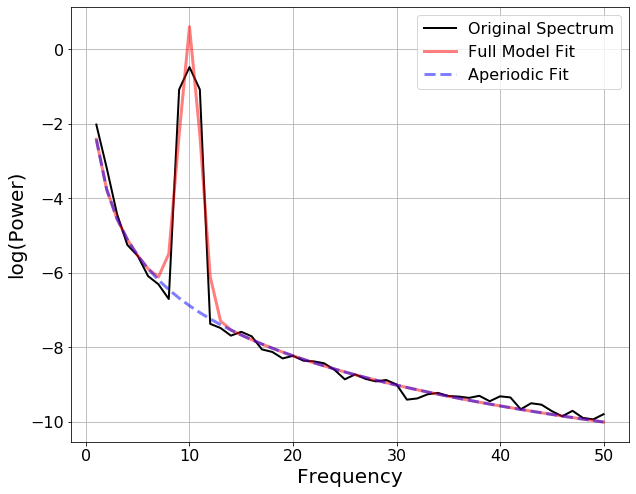

In [43]:
fs = 10**3
n_seconds = 10
times = create_times(n_seconds, fs)
f_range = (1, 50)

power_law_exp = -4
fm = FOOOF(peak_width_limits=[2.0, 8.0])

sim_components = {'sim_powerlaw': {'exponent' : power_law_exp},
                  'sim_oscillation': [{'freq' : 10},]}
sig = sim_combined(n_seconds, fs, sim_components)
freqs, psd = compute_spectrum(sig, fs)

fm.report(freqs, psd, f_range)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.2895, 1.7107                                          
                                                                                                  
                                       1 peaks were found:                                        
          

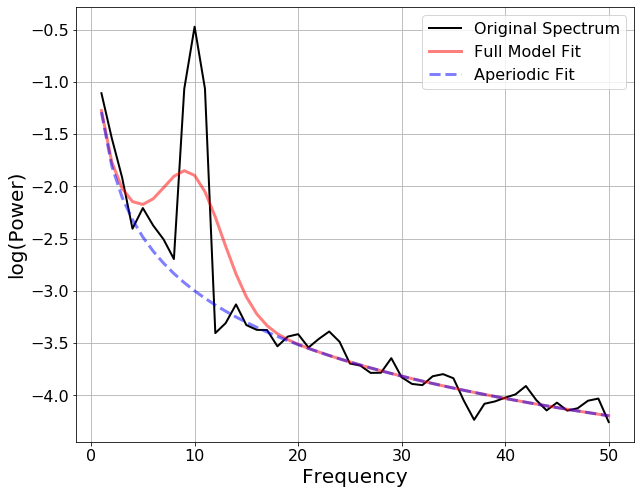

In [37]:
fs = 10**3
n_seconds = 10
times = create_times(n_seconds, fs)
f_range = (1, 50)

power_law_exp = -1.75
fm = FOOOF(peak_width_limits=[6.0, 8.0])

sim_components = {'sim_powerlaw': {'exponent' : power_law_exp},
                  'sim_oscillation': [{'freq' : 10},]}
sig = sim_combined(n_seconds, fs, sim_components)
freqs, psd = compute_spectrum(sig, fs)

fm.report(freqs, psd, f_range)

### FOOOF Sometimes Splits Low Frequency Peaks

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.9258, 1.7571                                          
                                                                                                  
                                       2 peaks were found:                                        
          

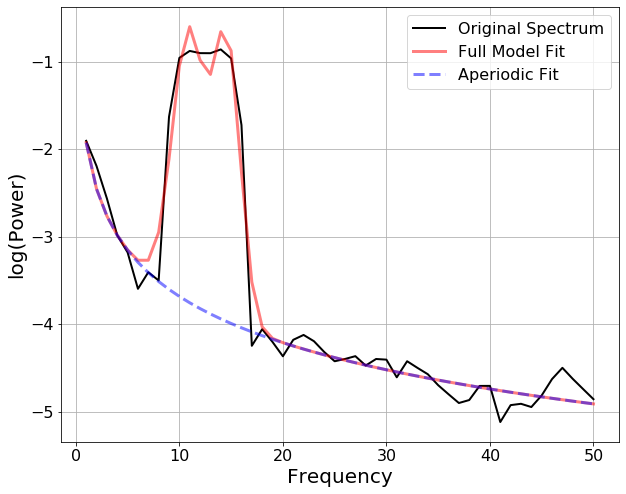

In [28]:
power_law_exp = -1.75
# For minimal peak width limits (2, 3, 4, 5) FOOOF will find two peaks
# but when minimal peak width is 6 it finds the true one peak. This seems
# a bit brittle.
fm = FOOOF(peak_width_limits=[2.0, 8.0])

sim_components = {'sim_powerlaw': {'exponent' : power_law_exp},
                  'sim_oscillation': [{'freq' : 10},
                                     {'freq' : 11},
                                     {'freq' : 12},
                                     {'freq' : 13},
                                     {'freq' : 14},
                                     {'freq' : 15},]}

sig = sim_combined(n_seconds, fs, sim_components)
freqs, psd = compute_spectrum(sig, fs)

fm.report(freqs, psd, f_range)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.7600, 1.6935                                          
                                                                                                  
                                       1 peaks were found:                                        
          

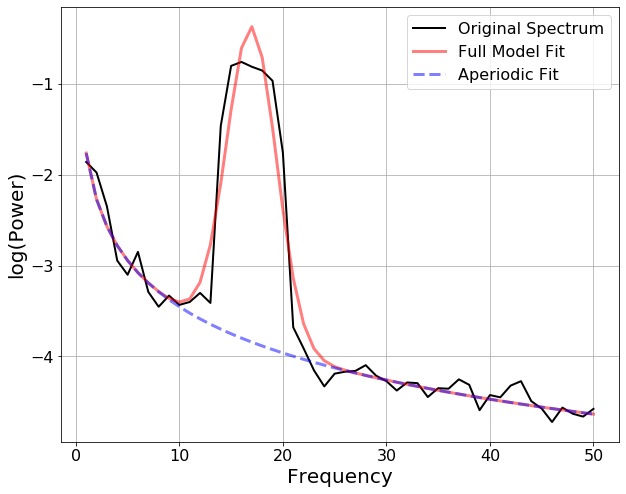

In [24]:
power_law_exp = -1.75
fm = FOOOF(peak_width_limits=[2.0, 8.0])

sim_components = {'sim_powerlaw': {'exponent' : power_law_exp},
                  'sim_oscillation': [{'freq' : 15},
                                     {'freq' : 16},
                                     {'freq' : 17},
                                     {'freq' : 18},
                                     {'freq' : 19},]}

sig = sim_combined(n_seconds, fs, sim_components)
freqs, psd = compute_spectrum(sig, fs)

fm.report(freqs, psd, f_range)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -2.0739, 1.7124                                          
                                                                                                  
                                       2 peaks were found:                                        
          

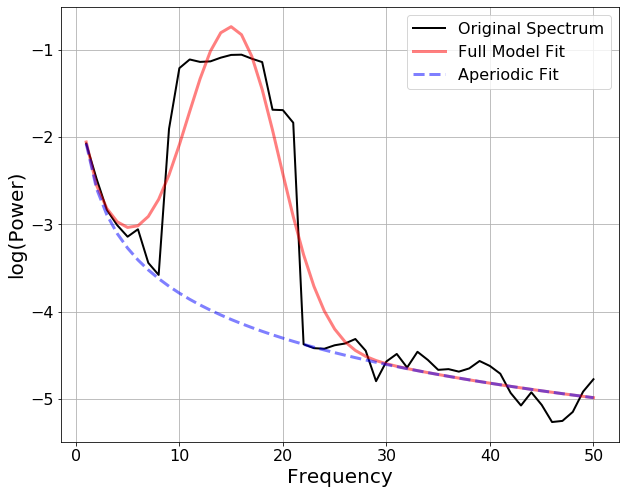

In [31]:
power_law_exp = -1.75
# For minimal peak width limits (2, 3, 4, 5) FOOOF will find two peaks
# but when minimal peak width is 6 it finds the true one peak. This seems
# a bit brittle.
fm = FOOOF(peak_width_limits=[8,15])

sim_components = {'sim_powerlaw': {'exponent' : power_law_exp},
                  'sim_oscillation': [{'freq' : 10},
                                     {'freq' : 11},
                                     {'freq' : 12},
                                     {'freq' : 13},
                                     {'freq' : 14},
                                     {'freq' : 15},
                                     {'freq' : 16},
                                     {'freq' : 17},
                                     {'freq' : 18},
                                     {'freq' : 19},
                                     {'freq' : 20}]}

sig = sim_combined(n_seconds, fs, sim_components)
freqs, psd = compute_spectrum(sig, fs)

fm.report(freqs, psd, f_range)